In [73]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [1]:
!pip install randaugment

In [14]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/effnetlite0')

In [5]:
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
#         transforms.RandomRotation(20),
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor()
 ]),
}

data_dir = '../statefarm_dataset_drivsep/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

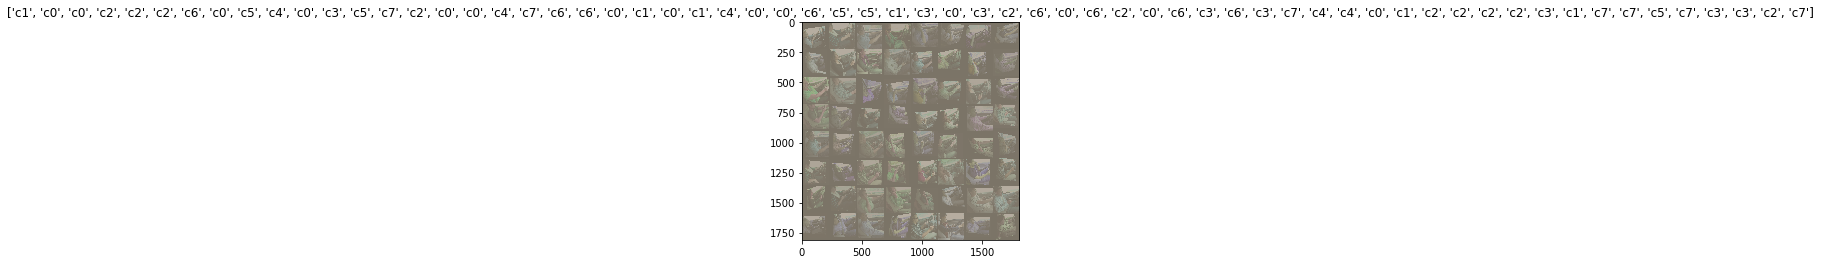

In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
            writer.add_scalar('Valid/Accuracy', best_acc, epoch)
            writer.flush()
            
            writer.add_scalar('Train/Loss', epoch_loss, epoch)
            writer.flush()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [2]:
model = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'tf_efficientnet_lite0', pretrained=True)


# for param in model.parameters():
#     param.requires_grad = False
    
model.classifier= nn.Sequential(
                      nn.Linear(1280, 10),                   
                     nn.LogSoftmax(dim=1))    
print(model.eval())

Using cache found in /home/mcw/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


GenEfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU6(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU6(inplace=True)
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=Tru

In [3]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

3,383,818 total parameters.
3,383,818 training parameters.


In [6]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.1)

In [29]:
model = train_model(model , criterion, optimizer_ft,exp_lr_scheduler,
                       num_epochs=20)

torch.save(model, 'models/effnet_lite.pt')

Epoch 0/1
----------
train Loss: 1.4665 Acc: 0.6724
valid Loss: 1.6643 Acc: 0.5157

Epoch 1/1
----------
train Loss: 1.3953 Acc: 0.6858
valid Loss: 1.6009 Acc: 0.5448

Training complete in 1m 8s
Best val Acc: 0.544823


In [76]:
from torchsummary import summary


In [80]:

def load_checkpoint(filepath):
    model = torch.load(filepath)
#     for parameter in model.parameters():
#         parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('models/effnetlite0_new.pt')
model.cuda()

GenEfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU6(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU6(inplace=True)
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=Tru

In [74]:
!pip install torchsummary

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
# labels is the image array
test_image = []
i = 0
# fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('../statefarm_dataset/test')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
#     print ('Image number:',i)
    img = cv2.imread('../statefarm_dataset/test/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
#     ax[i].imshow(img,cmap = 'gray')
    plt.show
print(img.shape)
test = []

for img in test_image:
    test.append(img)
    


(224, 224, 3)


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size

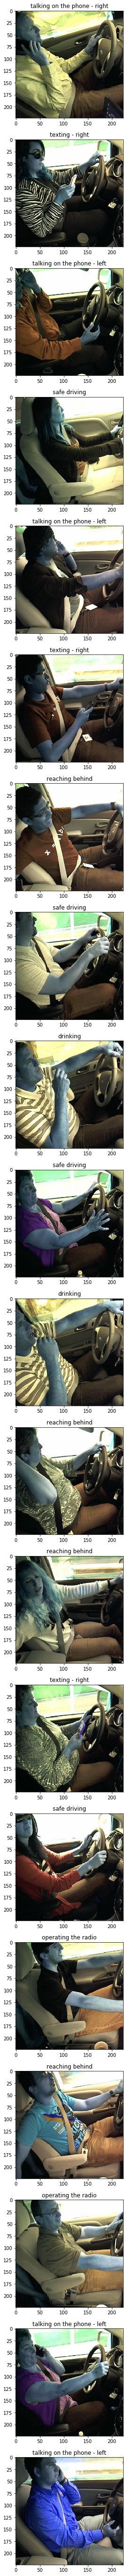

In [121]:
# from PIL import Image

def predict(img):
    trans = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        ])

    image = Image.fromarray((img))
    input = trans(image)
    print(input.shape)
    input = input.view(1, 3, 224,224)
    print(input.shape)

    # summary(model,(3,32, 32))

    output = model(input.cuda())
    prediction = torch.argmax(output)
    pred = prediction.cpu().numpy()
    return pred


fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i])
    predicted_class = 'C'+str(predict(test[i]))
    ax[i].set_title(tags[predicted_class])
    plt.show

In [ ]:
summary(model,(3,32, 32))